## Set up

Please obtain the raw data zip file and add it to your Google drive. Update line 4 of cell 1 to specify the path for where this data zip file is. 

The first cell configures the Google Colab environment to allow the repo to execute properly. Simply "Run All" to get started.

In [0]:
# Getting raw data
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/My Drive/JHU/2020 Spring Semester/Machine Learning: Deep Learning/Final Project/raw image.zip' -d /content/

# Organizing raw data
import os
from shutil import move

root = '/content/'
for filename in os.listdir(os.path.join(root, 'raw image')):
    move(os.path.join(root, 'raw image', filename), os.path.join(root, filename))

# Necessary installs to get code working on Google colab
!pip install libtiff

# Cloning core repo
!git clone https://github.com/Shu244/Cytometry-for-Google-Colab.git

# Updating environment variables
import sys
sys.path.append("/content/Cytometry-for-Google-Colab/Mask RCNN")

# Downgrading Tensorflow version
!pip install tensorflow-gpu==1.15.0

import tensorflow as tf
assert (tf.__version__ == "1.15.0"), "Restart runtime to use newly installed Tensorflow"

# Download pretrained COCO parameters
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5 -P /content/

# Unzip data
!unzip /content/Cytometry-for-Google-Colab/Data.zip

# Change into /content/ directory
%cd /content/Cytometry-for-Google-Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/JHU/2020 Spring Semester/Machine Learning: Deep Learning/Final Project/raw image.zip
  inflating: /content/raw image/GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3.tif  
replace /content/__MACOSX/raw image/._GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: /content/raw image/GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3@0001.tif  
fatal: destination path 'Cytometry-for-Google-Colab' already exists and is not an empty directory.
--2020-04-29 19:39:22--  https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github-production-release-asset-2e65be.s3.amazonaws.com/107595270

In [0]:
# Set matplotlib backend
# This has to be done before other importa that might
# set it, but only if we're running in script mode
# rather than being imported.
'''
if __name__ == '__main__':
    import matplotlib
    # Agg backend runs without a display
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
'''
import matplotlib.pyplot as plt
import json
import datetime
import xlrd
import cv2
import numpy as np
import skimage.io
from imgaug import augmenters as iaa
from libtiff import TIFF, TIFFfile

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Results directory
# Save submission files here
RESULTS_DIR = os.path.join(ROOT_DIR, "results/cellcount/")

from MRCNN.config import Config
import MRCNN.model as modellib
from MRCNN import utils, visualize

DataSize=100
Validation_ratio=0.1
Data_IDS=np.arange(1,DataSize+1,dtype=np.int16) 
VAL_IMAGE_IDS = np.random.choice(Data_IDS,size=np.int(Validation_ratio*DataSize),replace=False)
VAL_IMAGE_IDS.sort()

#####################################################
#         Configuration
#####################################################
class CellCountConfig(Config):
    NAME = 'CellCount'
    
    # Train on 1 GPU and 2 images per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # Background + RedBloodCell
    
    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0
    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"
    
    # Input image resizing
    IMAGE_RESIZE_MODE = "pad64"
    IMAGE_MIN_DIM = 812
    IMAGE_MAX_DIM = 1280
    IMAGE_SHAPE= (832, 1280, 3)
    
    IMAGE_CHANNEL_COUNT = 3   
    
    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 100

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 200
    
    
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    #RPN_NMS_THRESHOLD = 0.9
    RPN_NMS_THRESHOLD=0.95
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 500
    POST_NMS_ROIS_INFERENCE = 1000
    
    # Image mean (RGB)
    MEAN_PIXEL = (126,126,126)
        
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    #MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    MINI_MASK_SHAPE = (100,100)

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    #TRAIN_ROIS_PER_IMAGE = 128
    TRAIN_ROIS_PER_IMAGE = 256
    

#####################################################
#         Dataset
#####################################################
class CellDataset(utils.Dataset):
    
    def Image_gen(self, FileName):
        self.frame=0
        self.ImgeFile=FileName
        tif=TIFF.open(FileName)
        for Image_gened in tif.iter_images():
        #Image = imread(FileName,1)
            self.frame+=1
            yield Image_gened  
    
    def Image_getFrame(self, Image_dir, Frame):
        #if self.ImgeFile!=Image_dir or self.frame > Frame:
        Image_gen=self.Image_gen(Image_dir)
        self.frame=0
        im_getFrame=[]
        while self.frame<Frame:
            im_getFrame= next(Image_gen)
        im_getFrame=np.array(im_getFrame)
        return im_getFrame
            
    def load_cells(self, dataset_dir, subset):
        """
        Load a subset of the cell dataset.
        dataset_dir: Root directory of the dataset
        subset: Subset to load. 
                * train: training data excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """

        # Add classes. We have one class.
        # Naming the dataset Cells, and the 1st class RedBloodCell
        self.add_class("Cells", 1, "RBC")
        ROOT_PATH=os.path.dirname(os.getcwd())
        dataset_dir=os.path.join(ROOT_PATH,"Data",dataset_dir)
       # Train or validation dataset?
        assert subset in ["train", "val"]
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            if subset == "train":
                image_ids = list(set(Data_IDS) - set(VAL_IMAGE_IDS))
        # Add images
        for image_id in image_ids:
            self.add_image(
                "Cells",
                image_id=image_id,
                path=dataset_dir)
                  
    def load_image (self,image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        info = self.image_info[image_id]
        dataset_dir=info['path']
        data=xlrd.open_workbook(os.path.join(dataset_dir,'cellLabel.xlsx'))
        data=data.sheets()[0]
        Image_dir=os.path.join(os.path.dirname(os.getcwd()),data.col_values(0)[1])
        image=self.Image_getFrame(Image_dir, info['id'])
        # If grayscale. Convert to RGB for consistency.
        image=(image/np.max(image)*255).astype(np.float16)
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
        
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        dataset_dir=info['path']
        data=xlrd.open_workbook(os.path.join(dataset_dir,'cellLabel.xlsx'))
        data=data.sheets()[0]
        Frame=data.col_values(1)[1:]
        ClassName=data.col_values(2)[1:]
        
        MaskNum=data.col_values(4)[1:]
        ImgMask = [(Class,ImgMask) for [Class,ImgMask,frame] in zip(ClassName, MaskNum,Frame) if frame==info['id']]
        # Read mask files from .tif image
        Mask=[]
        ClassID=[]
        for i,Img in enumerate(ImgMask):
            # Get mask directory from image path
            mask_dir = os.path.join(info['path'], "{}.tif".format(Img[1]))
            #ID=[name['id'] for name in (self.class_info) if name.get('name')==Img[0]]
            ID=1
            im = cv2.imread(mask_dir,0).astype(np.bool)
            Mask.append(im)
            ClassID.append(ID)
        Mask = np.stack(Mask, axis=-1)
        ClassID= np.squeeze(np.array(ClassID))
        return Mask,ClassID
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "cells":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

############################################################
#  Training
############################################################

def train(model, dataset_dir, subset):
    """Train the model."""
    # Training dataset.
    dataset_train = CellDataset()
    dataset_train.load_cells(dataset_dir,"train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CellDataset()
    dataset_val.load_cells(dataset_dir, "val")
    dataset_val.prepare()
    
    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

    # If starting from imagenet, train heads only for a bit
    # since they have random weights
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                augmentation=augmentation,
                epochs=15,
                layers='4+')
    '''
    print("Train all layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=40,
                augmentation=augmentation,
                layers='all')
    '''

Using TensorFlow backend.


In [0]:
if __name__ == '__main__':
    os.environ['CUDA_VISIBLE_DEVICES'] = "1"
    config = CellCountConfig()
    #config.display()

    # Create model
    model = modellib.MaskRCNN(mode="training", config=config, model_dir=RESULTS_DIR)

    #Load COCO weights
    COCO_WEIGHTS_PATH = os.path.join(os.path.dirname(ROOT_DIR), "mask_rcnn_coco.h5")
    weights_path = COCO_WEIGHTS_PATH

    #weights_path = model.get_imagenet_weights()

    # Load weights
    model.load_weights(weights_path, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    #model.load_weights(weights_path, by_name=True)
    train(model=model, dataset_dir='val', subset='train')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Cytometry-for-Google-Colab/results/cellcount/cellcount20200429T1940/mask_rcnn_cellcount_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Co

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array
ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.U

Epoch 1/15
 99/100 [============================>.] - ETA: 0s - loss: 2.0211

ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array
ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array
ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call las

100/100 [==============================] - 72s 718ms/step - loss: 2.0138 - val_loss: 2.2541

Epoch 2/15
100/100 [==============================] - 44s 437ms/step - loss: 1.6305 - val_loss: 2.0331
Epoch 3/15
100/100 [==============================] - 44s 436ms/step - loss: 1.4180 - val_loss: 1.8044
Epoch 4/15
100/100 [==============================] - 43s 431ms/step - loss: 1.4104 - val_loss: 1.2167
Epoch 5/15
100/100 [==============================] - 43s 431ms/step - loss: 1.1696 - val_loss: 1.6774


ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array
ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array


Epoch 6/15
 99/100 [============================>.] - ETA: 0s - loss: 1.3491

ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array
ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array


100/100 [==============================] - 43s 431ms/step - loss: 1.3540 - val_loss: 2.0893
Epoch 7/15
100/100 [==============================] - 43s 431ms/step - loss: 1.3227 - val_loss: 1.2401
Epoch 8/15
100/100 [==============================] - 43s 431ms/step - loss: 1.2693 - val_loss: 1.6516
Epoch 9/15
100/100 [==============================] - 43s 433ms/step - loss: 1.0767 - val_loss: 1.7652
Epoch 10/15
100/100 [==============================] - 43s 431ms/step - loss: 1.1593 - val_loss: 1.8316


ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array


Epoch 11/15
 99/100 [============================>.] - ETA: 0s - loss: 1.0468

ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array


100/100 [==============================] - 43s 430ms/step - loss: 1.0428 - val_loss: 2.5805


ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array


Epoch 12/15
 99/100 [============================>.] - ETA: 0s - loss: 1.0738

ERROR:root:Error processing image {'id': 96, 'source': 'Cells', 'path': '/content/Data/val'}
Traceback (most recent call last):
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1707, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/Cytometry-for-Google-Colab/Mask RCNN/MRCNN/model.py", line 1263, in load_image_gt
    class_ids = class_ids[_idx]
IndexError: too many indices for array


100/100 [==============================] - 43s 429ms/step - loss: 1.0733 - val_loss: 1.1459
Epoch 13/15
100/100 [==============================] - 43s 432ms/step - loss: 1.0146 - val_loss: 0.8705
Epoch 14/15
100/100 [==============================] - 43s 430ms/step - loss: 1.0144 - val_loss: 1.9398
Epoch 15/15
100/100 [==============================] - 43s 430ms/step - loss: 0.8930 - val_loss: 0.8854


In [0]:
############################################################
#  Detection
############################################################
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = CellCountConfig()

#Create Model
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=RESULTS_DIR)

#Load weights
import glob

list_of_folders = glob.glob("/content/Cytometry-for-Google-Colab/results/cellcount/*") 
latest_folder = max(list_of_folders, key=os.path.getctime)

list_of_files = glob.glob(os.path.join(latest_folder, "*"))
latest_file = max(list_of_files, key=os.path.getctime)

weights_path = latest_file

# Load weights
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 15


--------------------------------
Frame ID = 2
Ground Truth Cell Number =  6
Detected Cell Number = 6


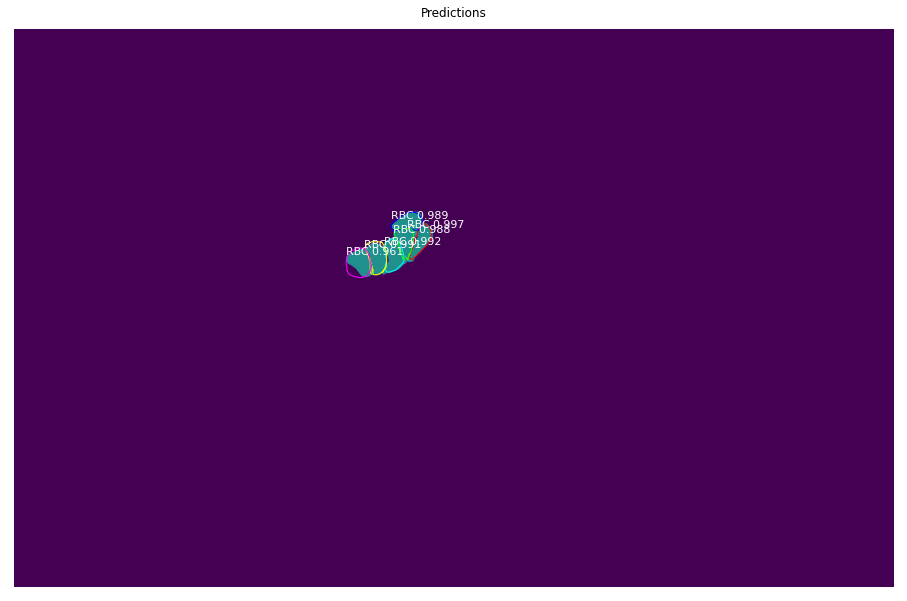

--------------------------------
Frame ID = 3
Ground Truth Cell Number =  6
Detected Cell Number = 4


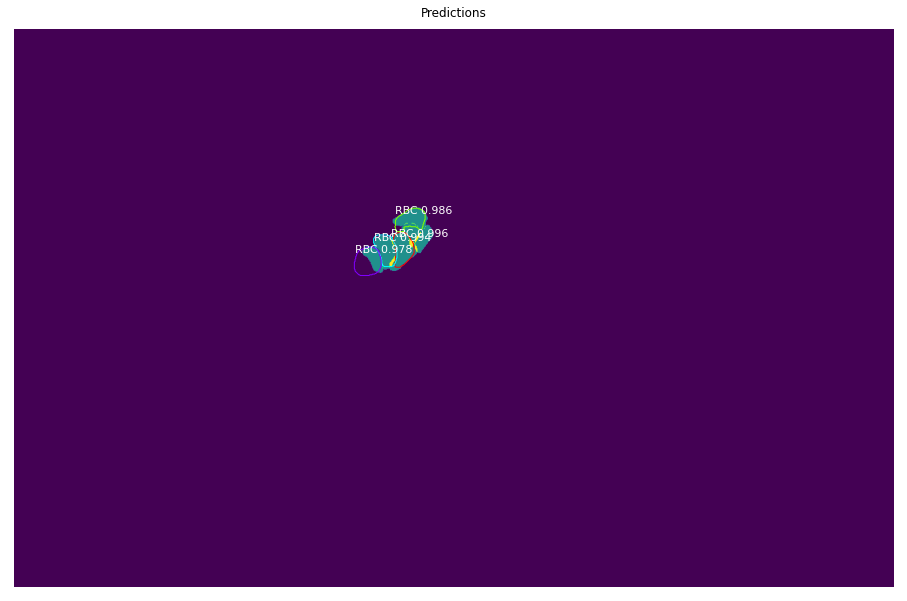

--------------------------------
Frame ID = 4
Ground Truth Cell Number =  7
Detected Cell Number = 5


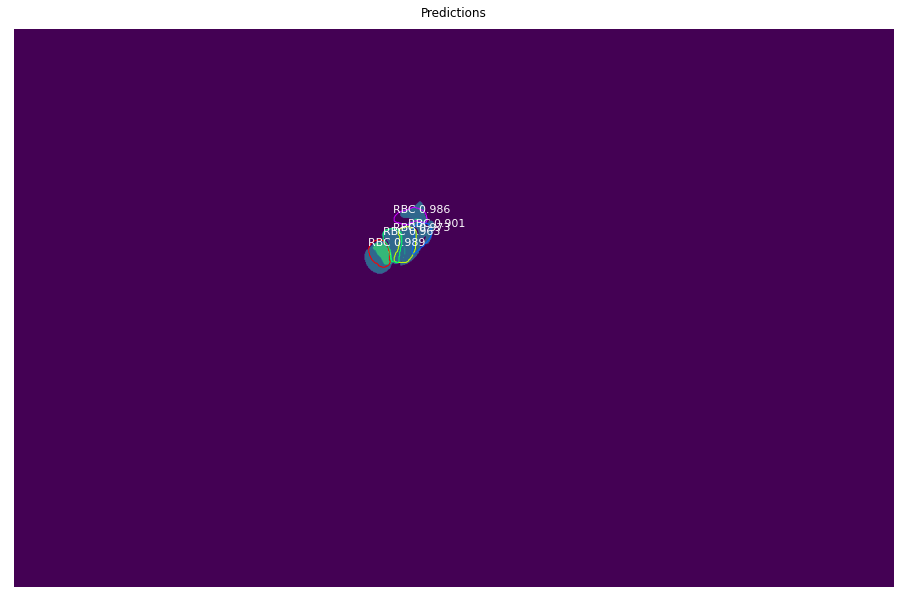

--------------------------------
Frame ID = 5
Ground Truth Cell Number =  4
Detected Cell Number = 4


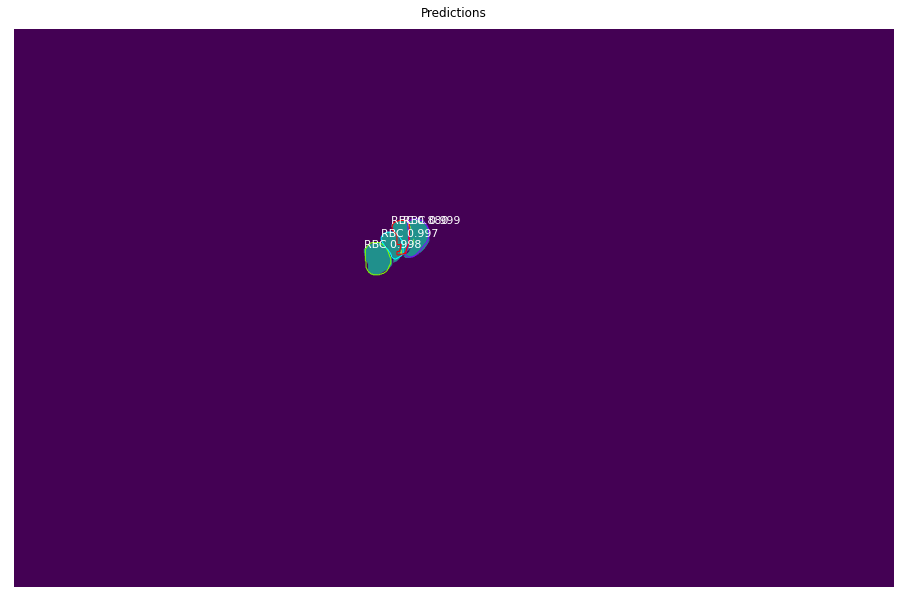

--------------------------------
Frame ID = 6
Ground Truth Cell Number =  5
Detected Cell Number = 4


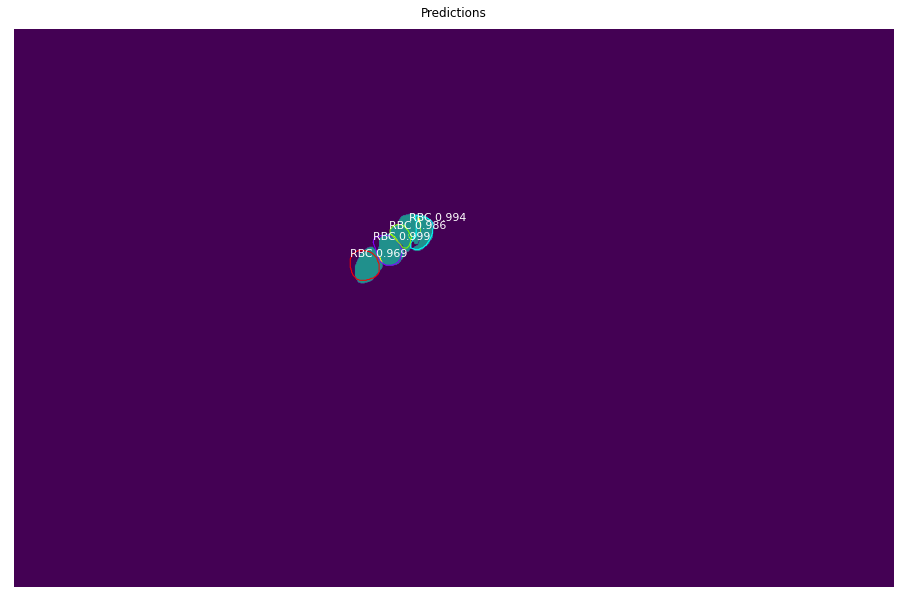

--------------------------------
Frame ID = 7
Ground Truth Cell Number =  4
Detected Cell Number = 3


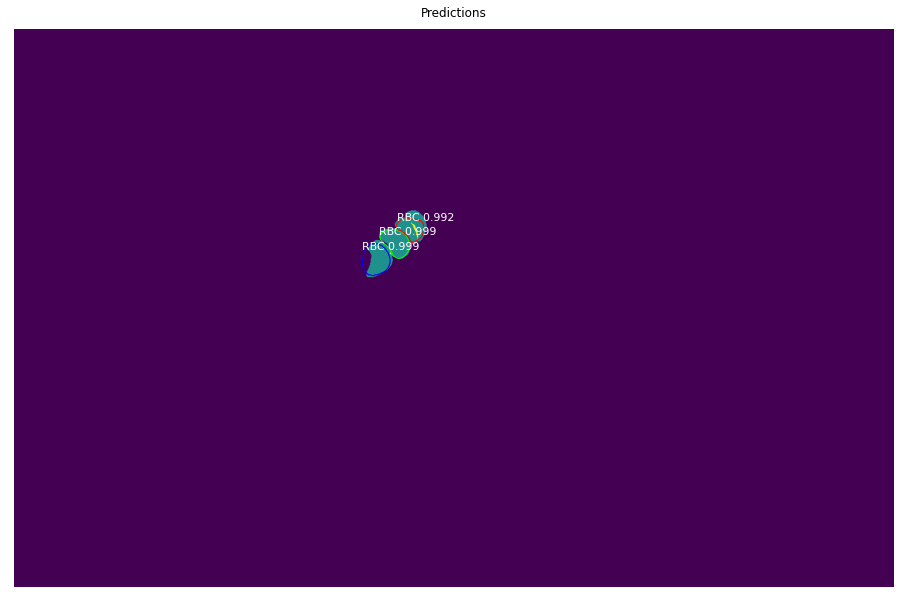

--------------------------------
Frame ID = 8
Ground Truth Cell Number =  3
Detected Cell Number = 3


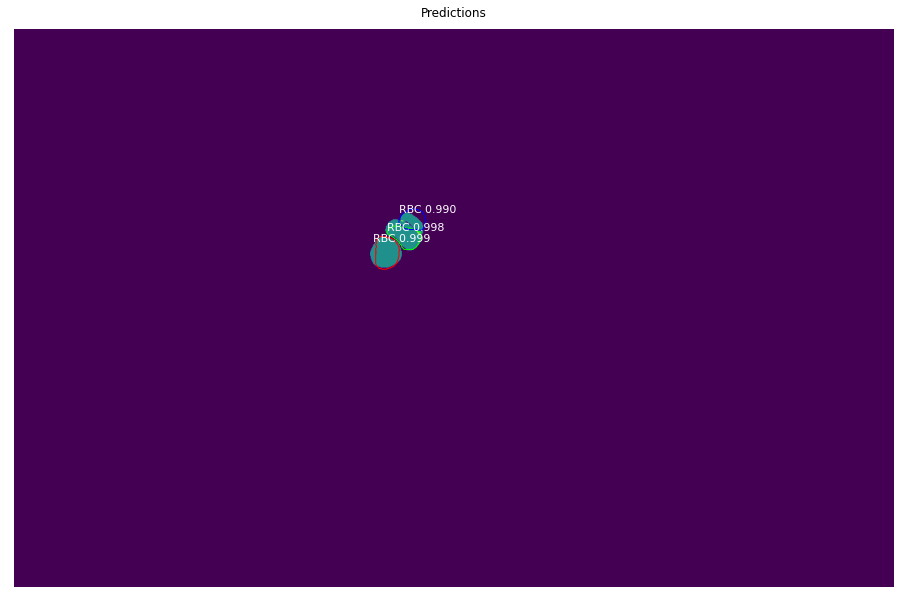

--------------------------------
Frame ID = 9
Ground Truth Cell Number =  3
Detected Cell Number = 3


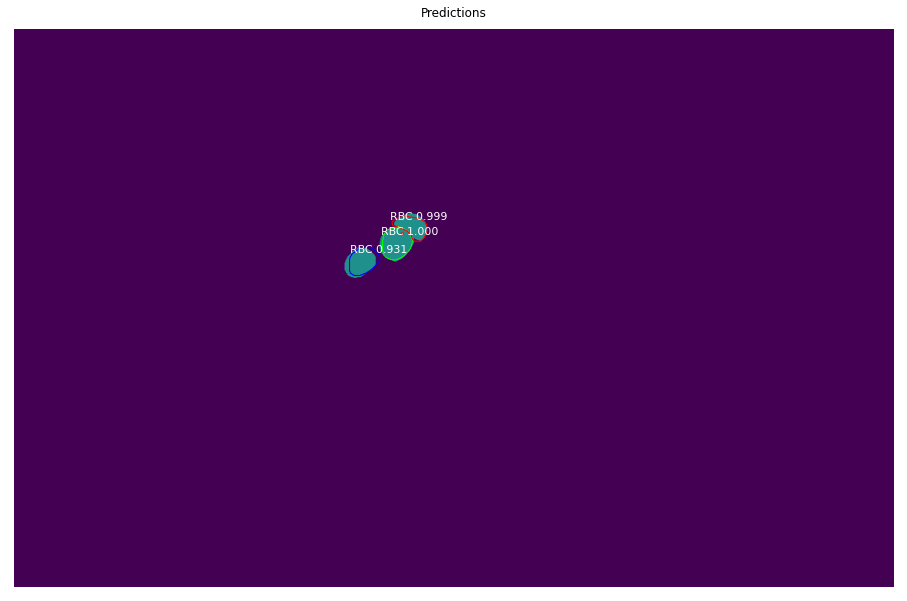

--------------------------------
Frame ID = 10
Ground Truth Cell Number =  2
Detected Cell Number = 2


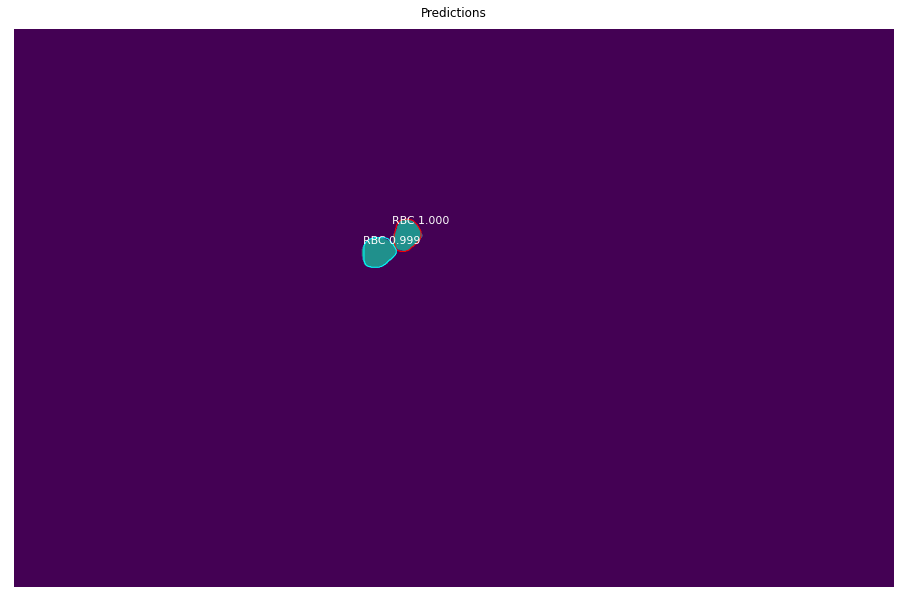

--------------------------------
Frame ID = 11
Ground Truth Cell Number =  3
Detected Cell Number = 3


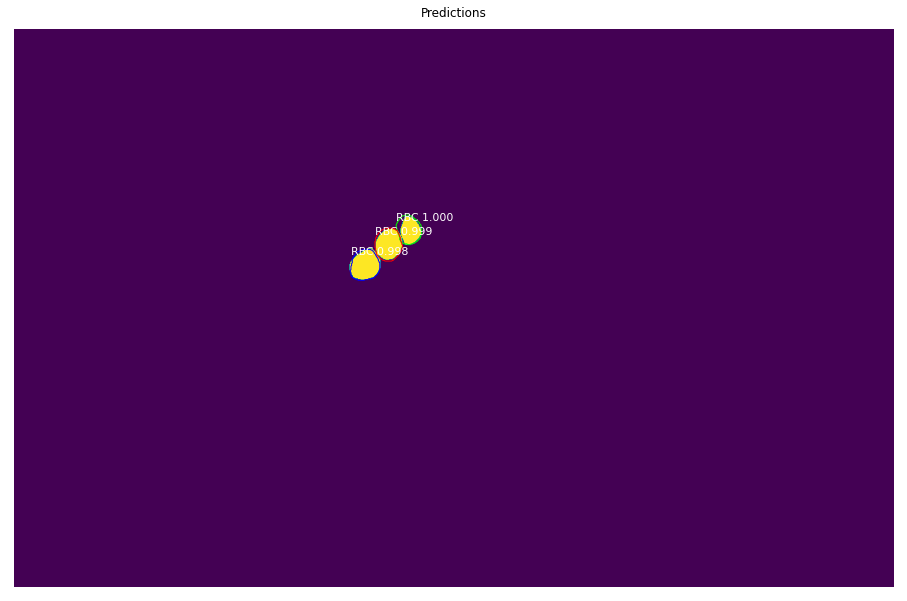

--------------------------------
Frame ID = 12
Ground Truth Cell Number =  2
Detected Cell Number = 3


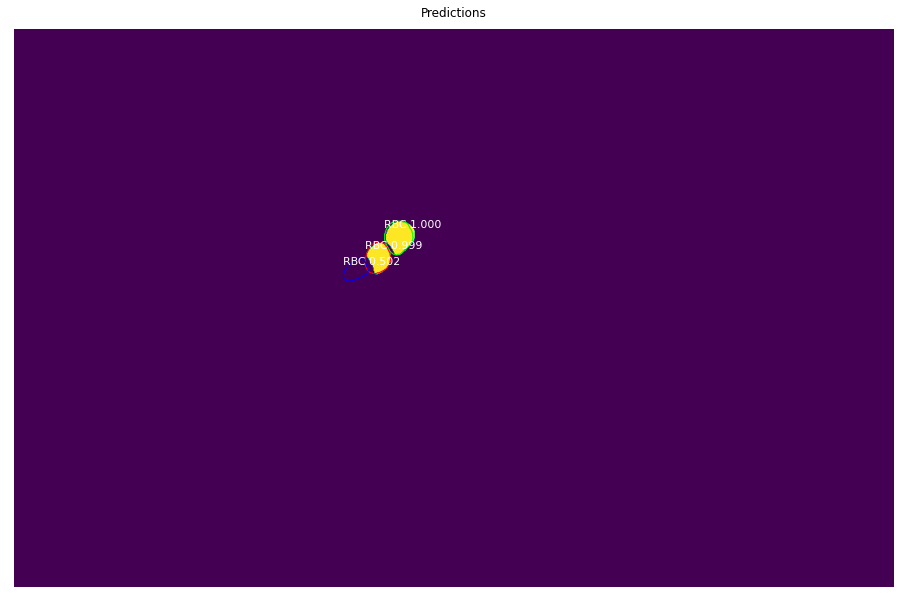

--------------------------------
Frame ID = 13
Ground Truth Cell Number =  4
Detected Cell Number = 4


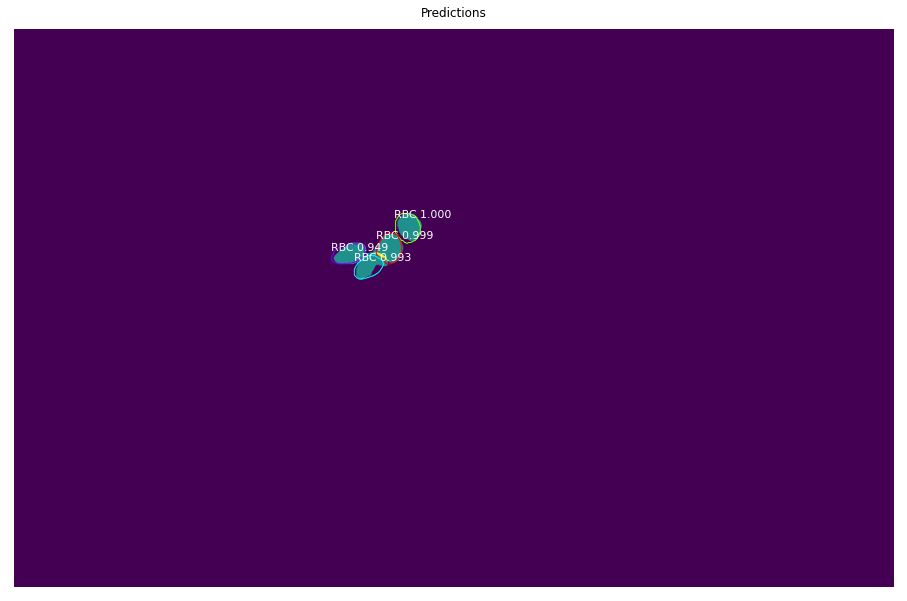

--------------------------------
Frame ID = 14
Ground Truth Cell Number =  5
Detected Cell Number = 5


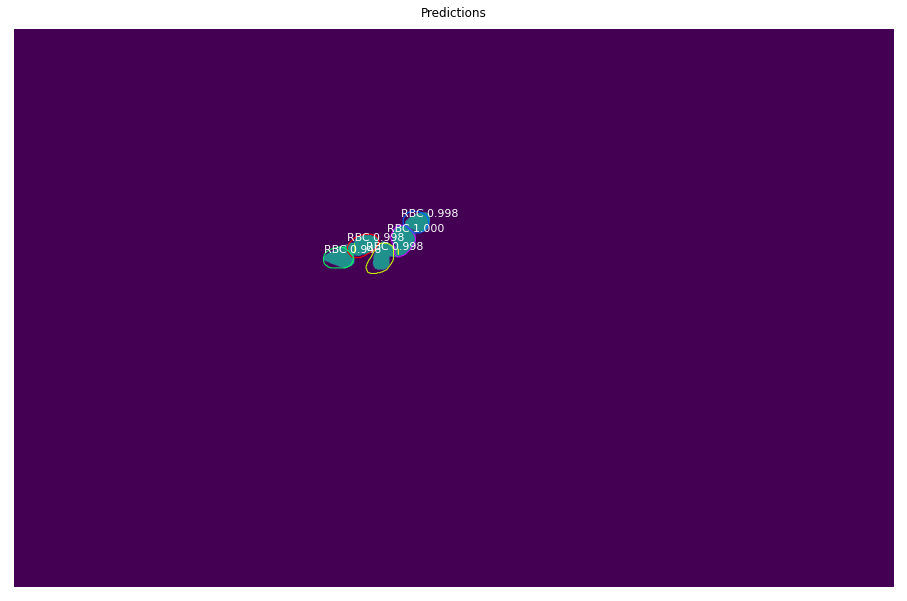

--------------------------------
Frame ID = 15
Ground Truth Cell Number =  5
Detected Cell Number = 3


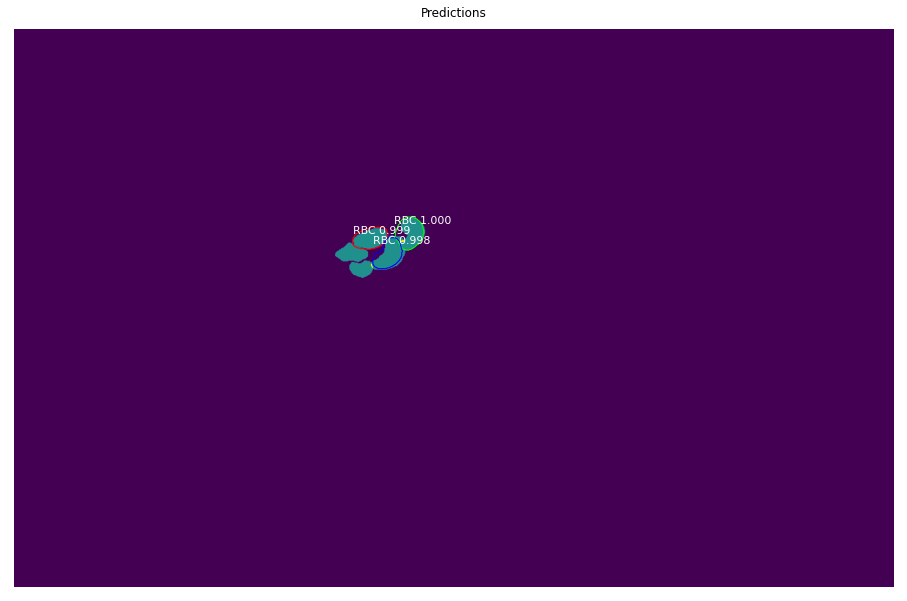

--------------------------------
Frame ID = 16
Ground Truth Cell Number =  5
Detected Cell Number = 4


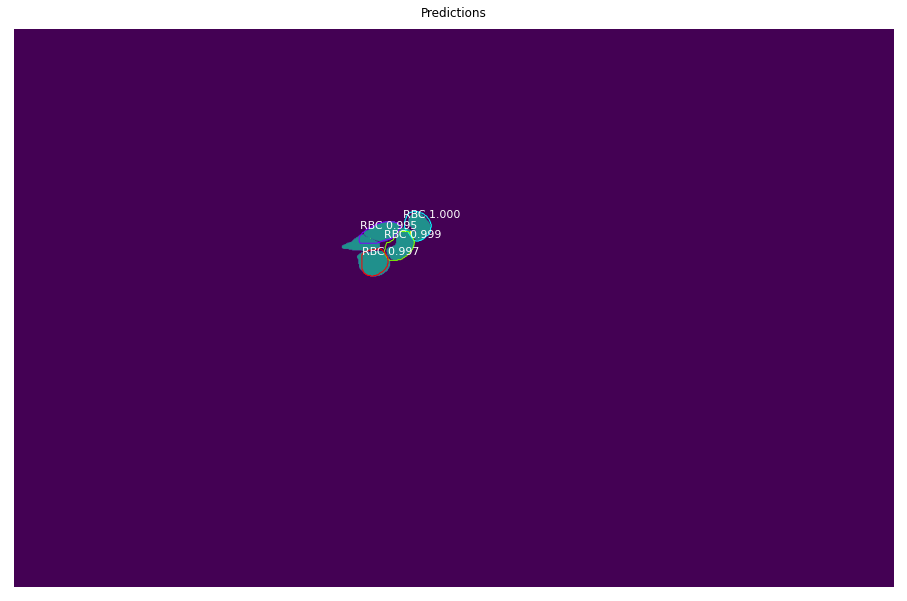

--------------------------------
Frame ID = 17
Ground Truth Cell Number =  5
Detected Cell Number = 5


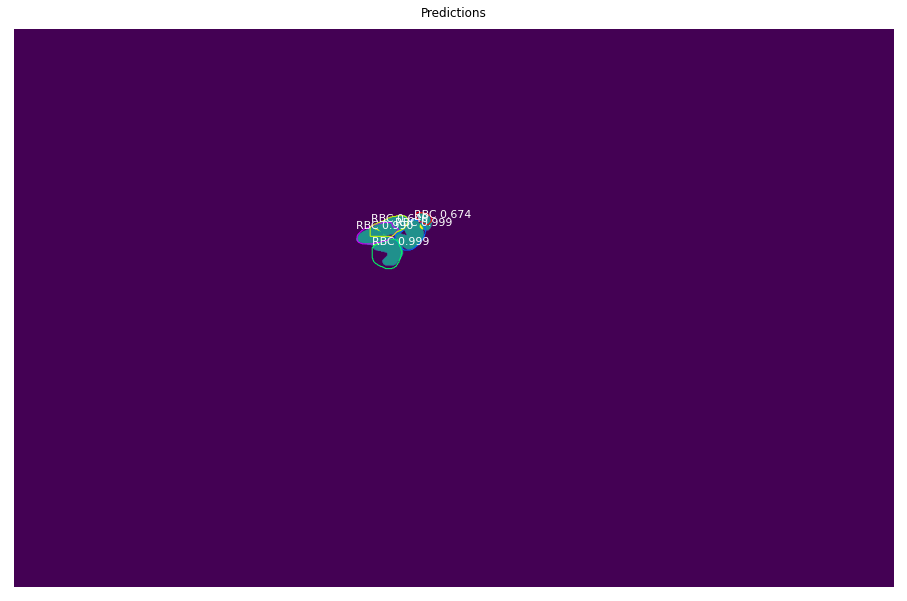

--------------------------------
Frame ID = 18
Ground Truth Cell Number =  7
Detected Cell Number = 6


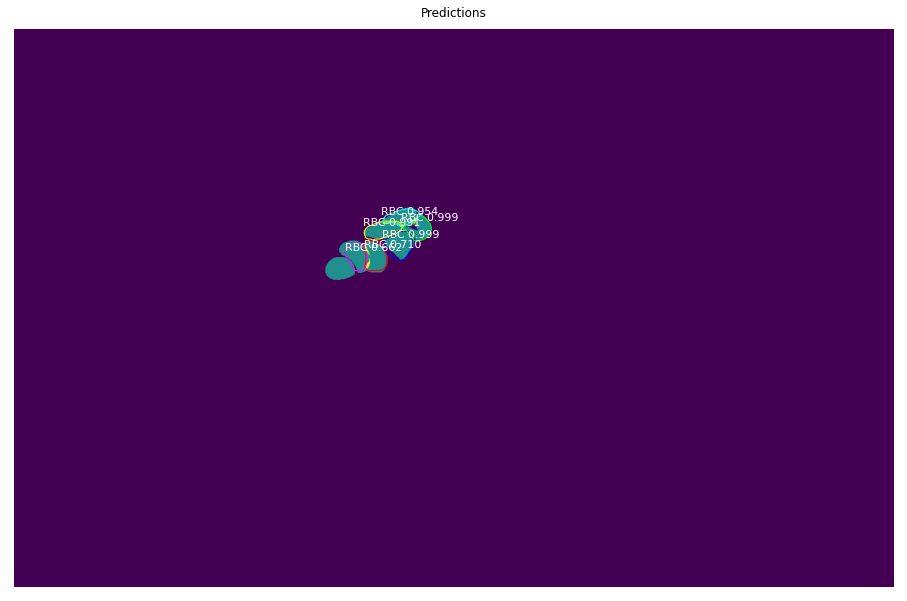

--------------------------------
Frame ID = 19
Ground Truth Cell Number =  7
Detected Cell Number = 5


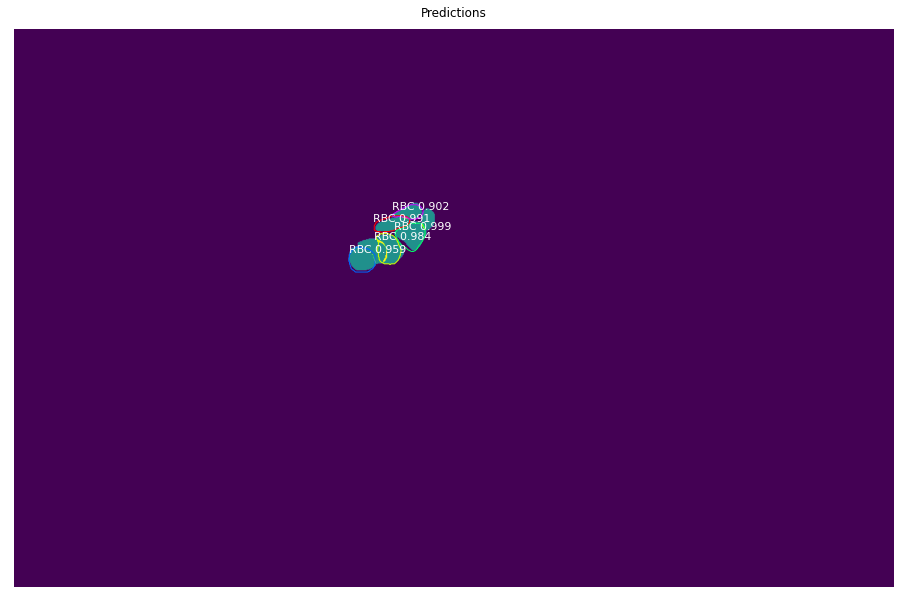

--------------------------------
Frame ID = 20
Ground Truth Cell Number =  7
Detected Cell Number = 5


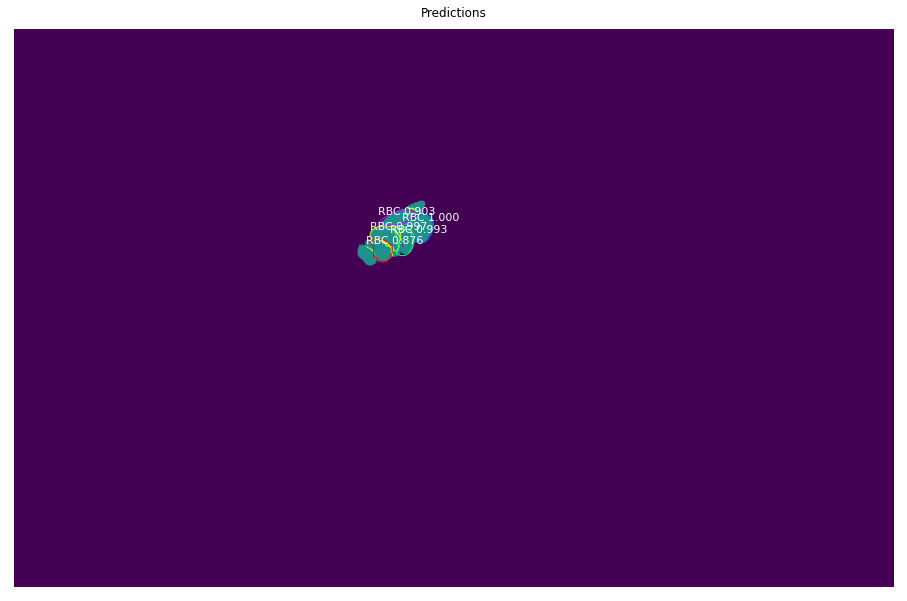

--------------------------------
Frame ID = 21
Ground Truth Cell Number =  6
Detected Cell Number = 4


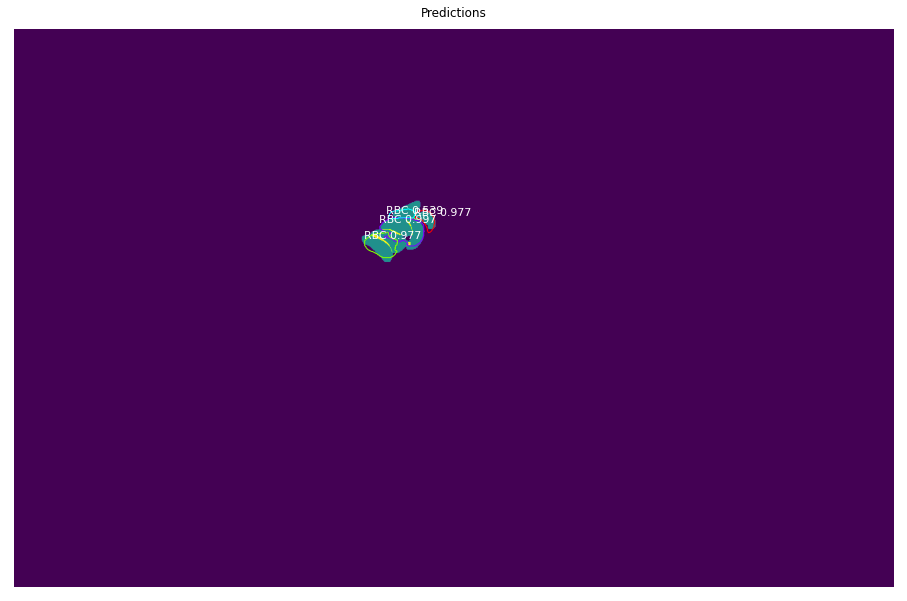

--------------------------------
Frame ID = 22
Ground Truth Cell Number =  5
Detected Cell Number = 5


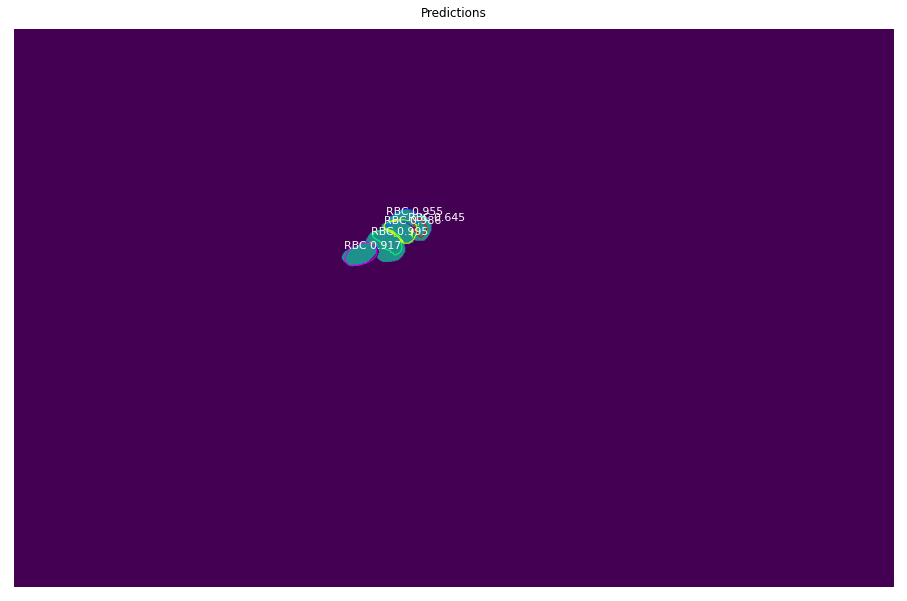

--------------------------------
Frame ID = 23
Ground Truth Cell Number =  5
Detected Cell Number = 4


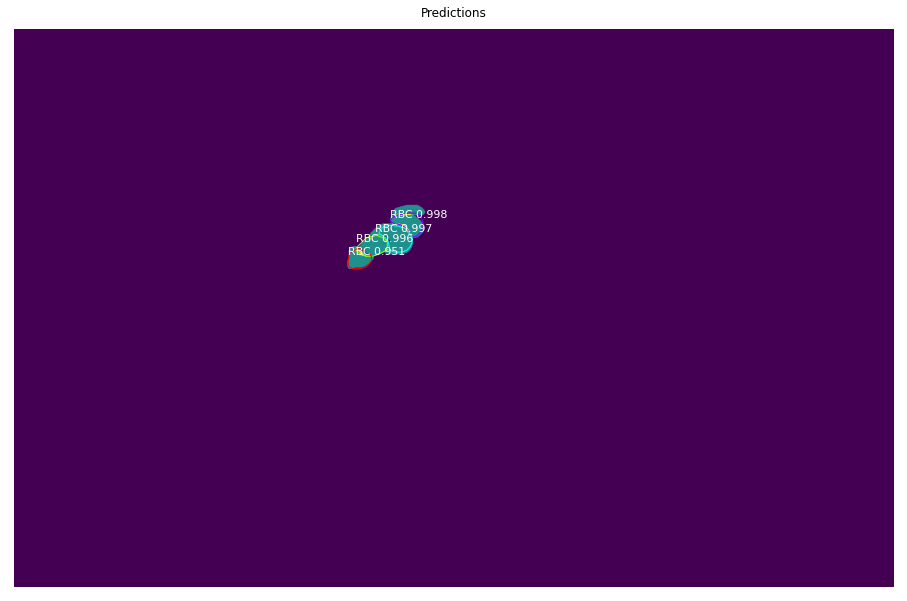

--------------------------------
Frame ID = 24
Ground Truth Cell Number =  4
Detected Cell Number = 4


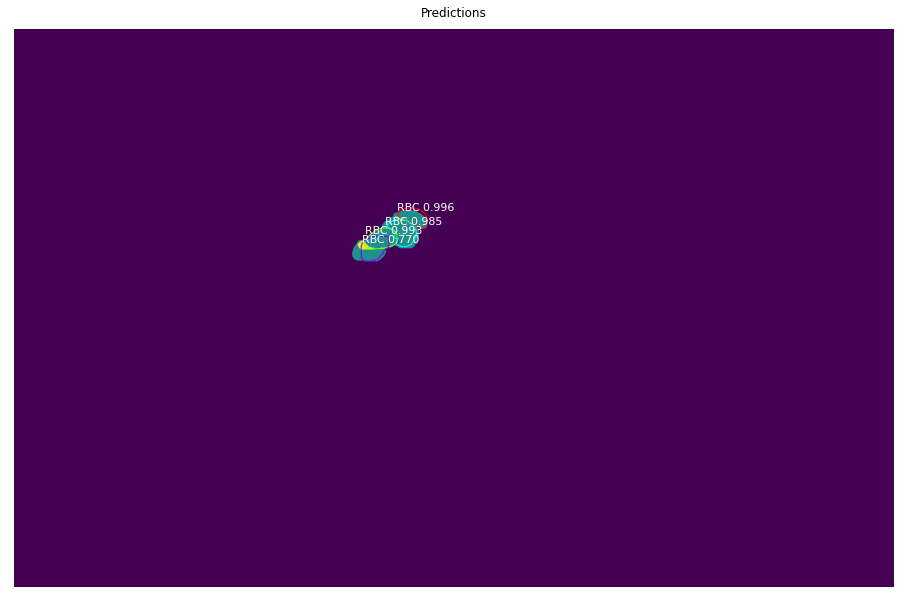

--------------------------------
Frame ID = 25
Ground Truth Cell Number =  5
Detected Cell Number = 4


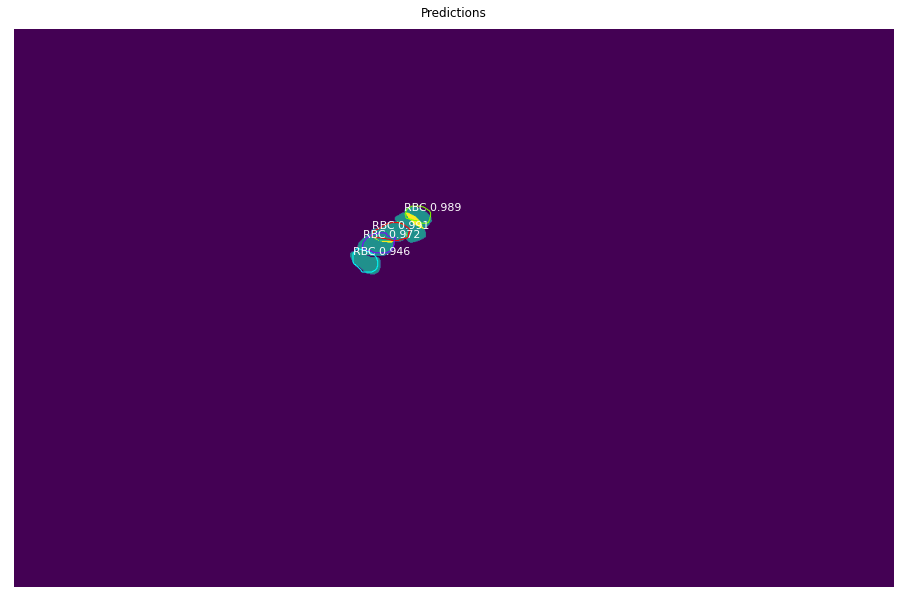

--------------------------------
Frame ID = 26
Ground Truth Cell Number =  3
Detected Cell Number = 3


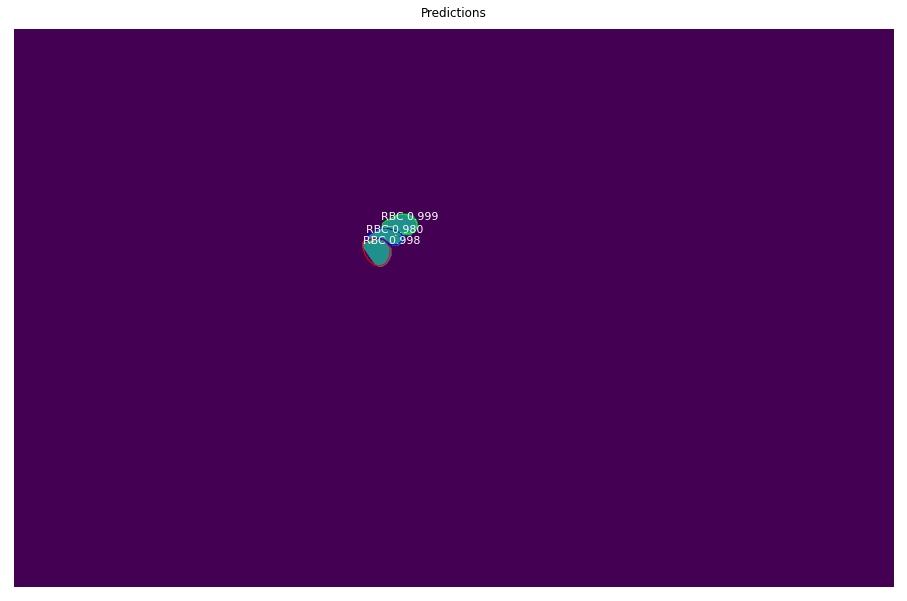

--------------------------------
Frame ID = 27
Ground Truth Cell Number =  3
Detected Cell Number = 3


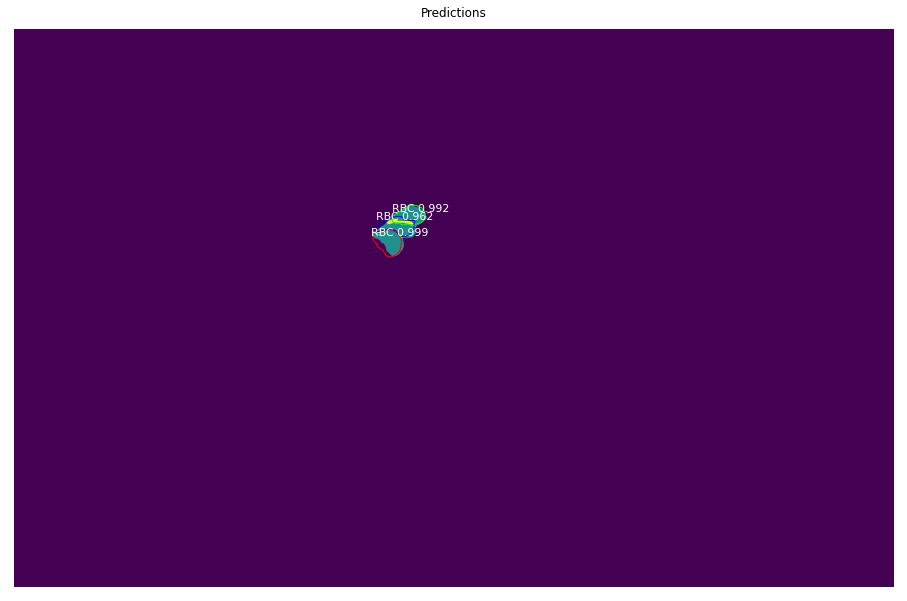

--------------------------------
Frame ID = 28
Ground Truth Cell Number =  3
Detected Cell Number = 3


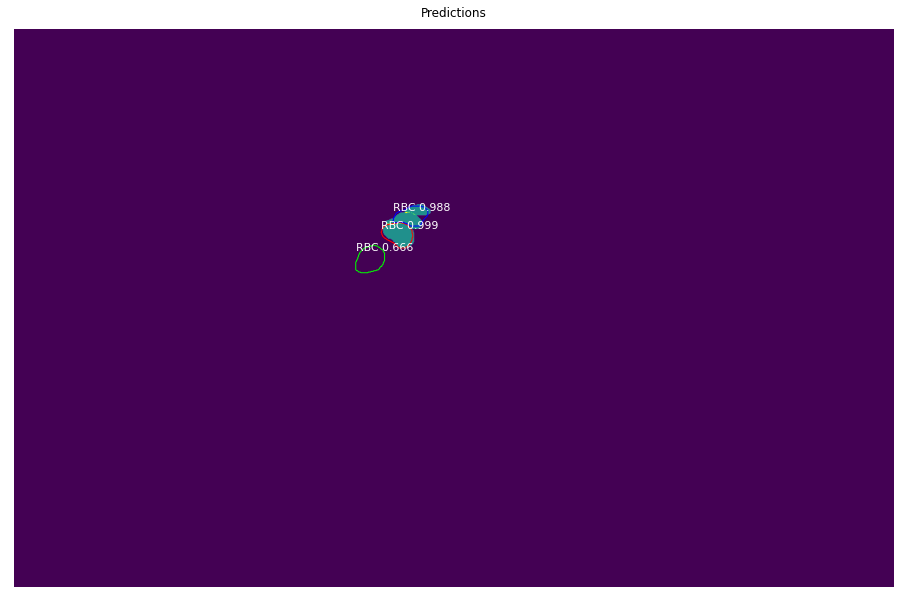

In [0]:
# Read dataset
dataset = CellDataset()
dataset.load_cells('val', 'train')
dataset.prepare()

GT_no=[]
DE_no=[]
for image_id in range (1,28):
    # Load image and run detection
    image = dataset.load_image(image_id)
    mask,class_id= dataset.load_mask(image_id)
    # Detect objects
    r = model.detect([image], verbose=0)[0]
    # Encode image to RLE. Returns a string of multiple lines
    source_id = dataset.image_info[image_id]["id"]
    #rle = mask_to_rle(source_id, r["masks"], r["scores"])
    #submission.append(rle)
    GT_no.append(np.size(mask,2))
    DE_no.append(len(r['class_ids']))
    print('--------------------------------')
    print('Frame ID =', dataset.image_info[image_id]["id"])
    print('Ground Truth Cell Number = ', GT_no[-1])
    print('Detected Cell Number =', DE_no[-1])
    visualize.display_instances(
        np.sum(mask,axis=2), r['rois'], r['masks'], r['class_ids'],
        dataset.class_names, r['scores'],
        show_bbox=False, show_mask=False,
        title="Predictions")

--------------------------------
Frame ID = 28
Ground Truth Cell Number =  3
Detected Cell Number = 3


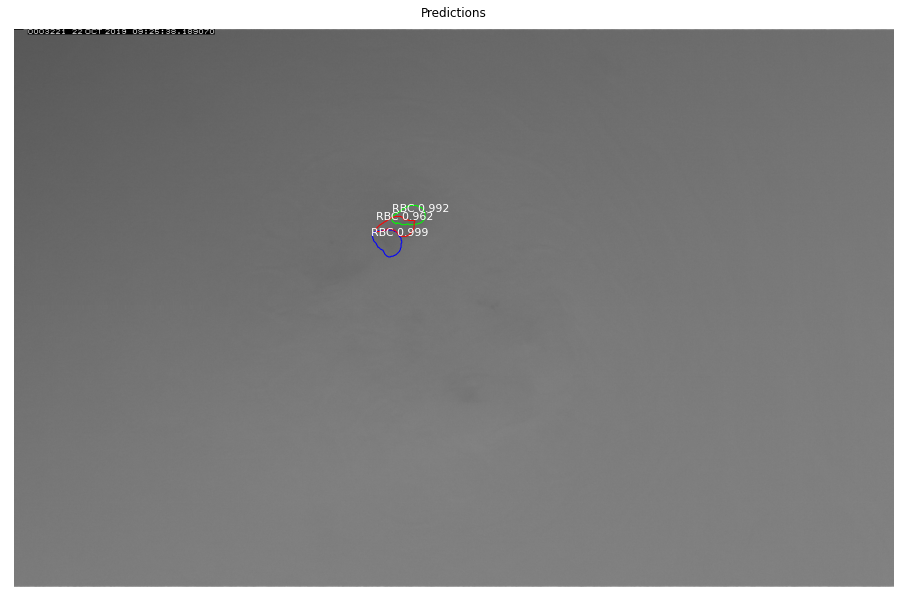

In [0]:
# Read dataset
dataset = CellDataset()
dataset.load_cells('val', 'train')
dataset.prepare()
im_dir='../GFC_505nm_40X1p15NA_PCO_500usexp_160fps_3@0001.tif'
image =dataset.Image_getFrame(im_dir,27)
if image.ndim != 3:
    image = skimage.color.gray2rgb(image)
# If has an alpha channel, remove it for consistency
if image.shape[-1] == 4:
    image = image[..., :3]
image=(image/np.max(image)*255).astype(np.float16)
# Detect objects
r = model.detect([image], verbose=0)[0]
# Encode image to RLE. Returns a string of multiple lines
source_id = dataset.image_info[image_id]["id"]
#rle = mask_to_rle(source_id, r["masks"], r["scores"])
#submission.append(rle)
GT_no.append(np.size(mask,2))
DE_no.append(len(r['class_ids']))
print('--------------------------------')
print('Frame ID =', dataset.image_info[image_id]["id"])
print('Ground Truth Cell Number = ', GT_no[-1])
print('Detected Cell Number =', DE_no[-1])
#bg=np.zeros(np.shape(image))
visualize.display_instances(
    image, r['rois'], r['masks'], r['class_ids'],
    dataset.class_names, r['scores'],
    show_bbox=False, show_mask=False,
    title="Predictions")

In [0]:
############################################################
#  Detection
############################################################

def detect(model, dataset_dir, subset):
    """Run detection on images in the given directory."""
    print("Running on {}".format(dataset_dir))

    # Create directory
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    submit_dir = "submit_{:%Y%m%dT%H%M%S}".format(datetime.datetime.now())
    submit_dir = os.path.join(RESULTS_DIR, submit_dir)
    os.makedirs(submit_dir)

    # Read dataset
    dataset = CellDataset()
    dataset.load_cells(dataset_dir, subset)
    dataset.prepare()
    # Load over images
    submission = []
    for image_id in dataset.image_ids:
        # Load image and run detection
        image = dataset.load_image(image_id)
        # Detect objects
        r = model.detect([image], verbose=0)[0]
        # Encode image to RLE. Returns a string of multiple lines
        source_id = dataset.image_info[image_id]["id"]
        rle = mask_to_rle(source_id, r["masks"], r["scores"])
        submission.append(rle)
        # Save image with masks
        visualize.display_instances(
            image, r['rois'], r['masks'], r['class_ids'],
            dataset.class_names, r['scores'],
            show_bbox=False, show_mask=False,
            title="Predictions")
        plt.savefig("{}/{}.png".format(submit_dir, dataset.image_info[image_id]["id"]))

    # Save to csv file
    submission = "ImageId,EncodedPixels\n" + "\n".join(submission)
    file_path = os.path.join(submit_dir, "submit.csv")
    with open(file_path, "w") as f:
        f.write(submission)
    print("Saved to ", submit_dir)

In [0]:
np.max(image)

255.0